# iCubWorld1 CNN Experiment Notebook

This notebook contains:
1. Data preprocessing and train/validation split
2. Model definition 
3. Loss function, optimizer and learning rate scheduling
4. Training and validation functions
5. Training loop and early stopping
6. Hyperparameter grid search example
7. Final training & testing on four modes
8. Results visualization


In [1]:
import os, random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ramdom seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## 数据预处理与训练/验证集划分

In [3]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ColorJitter(0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


base_ds = datasets.ImageFolder('Dataset/iCubWorld1/train', transform=None)
num_classes = len(base_ds.classes)

# 80/20 split   
indices = list(range(len(base_ds)))
random.shuffle(indices)
split = int(0.9 * len(indices))
train_idx, val_idx = indices[:split], indices[split:]

class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        return self.transform(img), label

train_ds = TransformSubset(Subset(base_ds, train_idx), train_transforms)
val_ds   = TransformSubset(Subset(base_ds, val_idx),   val_transforms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)

print(len(train_ds), 'train samples,', len(val_ds), 'val samples')
print('Classes:', base_ds.classes)

5401 train samples, 601 val samples
Classes: ['bananas', 'bottles', 'boxes', 'bread', 'cans', 'lemons', 'pears', 'peppers', 'potatoes', 'yogurt']


## 模型定义

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128),nn.ReLU(),nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = SimpleCNN(num_classes).to(device)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU()
    (3): Drop

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            # 全局平均池化替代大尺寸展平
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# print model summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=num_classes).to(device)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=

## Loss Function, Optimizer and Learning Rate Scheduling


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)


## Train and eval functions

In [6]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        _, preds = out.max(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
    return total_loss/total, correct/total

def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            _, preds = out.max(1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    return total_loss/total, correct/total

##  Training loop and early stopping

In [8]:
best_val_acc = 0
epochs_no_improve = 0
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, 51):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss,   val_acc   = eval_one_epoch(model, val_loader,   criterion)
    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}: Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= 10:
        print('Early stopping triggered')
        break

Epoch 1: Train Acc=0.527, Val Acc=0.686
Epoch 2: Train Acc=0.744, Val Acc=0.847
Epoch 3: Train Acc=0.811, Val Acc=0.902
Epoch 4: Train Acc=0.851, Val Acc=0.892
Epoch 5: Train Acc=0.874, Val Acc=0.948
Epoch 6: Train Acc=0.886, Val Acc=0.962
Epoch 7: Train Acc=0.903, Val Acc=0.963
Epoch 8: Train Acc=0.914, Val Acc=0.985
Epoch 9: Train Acc=0.926, Val Acc=0.985
Epoch 10: Train Acc=0.924, Val Acc=0.988
Epoch 11: Train Acc=0.946, Val Acc=0.995
Epoch 12: Train Acc=0.940, Val Acc=0.978
Epoch 13: Train Acc=0.947, Val Acc=0.995
Epoch 14: Train Acc=0.956, Val Acc=0.985
Epoch 15: Train Acc=0.956, Val Acc=0.998
Epoch 16: Train Acc=0.966, Val Acc=0.998
Epoch 17: Train Acc=0.959, Val Acc=0.998
Epoch 18: Train Acc=0.965, Val Acc=0.985
Epoch 19: Train Acc=0.968, Val Acc=0.995
Epoch 20: Train Acc=0.967, Val Acc=0.995
Epoch 21: Train Acc=0.965, Val Acc=0.995
Epoch 22: Train Acc=0.966, Val Acc=0.993
Epoch 23: Train Acc=0.972, Val Acc=0.993
Epoch 24: Train Acc=0.976, Val Acc=0.997
Epoch 25: Train Acc=0.971

## Hyperparameter grid search smaple

In [9]:
import itertools
import pandas as pd
from torch.utils.data import DataLoader

param_grid = {
    'lr': [1e-3, 5e-4],
    'optimizer': ['SGD', 'Adam'],
    'batch_size': [32, 64],
    'weight_decay': [1e-4, 0]
}
results = []
for lr, opt, bs, wd in itertools.product(param_grid['lr'],
                                         param_grid['optimizer'],
                                         param_grid['batch_size'],
                                         param_grid['weight_decay']):
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=4)
    model_hp = SimpleCNN(num_classes).to(device)
    optimizer_hp = (optim.SGD(model_hp.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
                    if opt=='SGD' else optim.Adam(model_hp.parameters(), lr=lr, weight_decay=wd))
    scheduler_hp = optim.lr_scheduler.ReduceLROnPlateau(optimizer_hp, 'min', factor=0.5, patience=3)

    best_acc = 0
    for epoch in range(1, 11):
        train_one_epoch(model_hp, train_loader, optimizer_hp, criterion)
        val_loss, val_acc = eval_one_epoch(model_hp, val_loader, criterion)
        scheduler_hp.step(val_loss)
        best_acc = max(best_acc, val_acc)

    results.append({
        'lr': lr, 'optimizer': opt,
        'batch_size': bs, 'weight_decay': wd,
        'best_val_acc': best_acc
    })

df_results = pd.DataFrame(results)
display(df_results.sort_values('best_val_acc', ascending=False).head())

,lr,optimizer,batch_size,weight_decay,best_val_acc
3,0.0010,SGD,64,0.0000,0.988353
2,0.0010,SGD,64,0.0001,0.988353
10,0.0005,SGD,64,0.0001,0.986689
1,0.0010,SGD,32,0.0000,0.985025
8,0.0005,SGD,32,0.0001,0.985025


## Trainng the final model on the full training set

In [13]:
best = df_results.sort_values('best_val_acc', ascending=False).iloc[0]
print('Best hyperparams:', best.to_dict())

# 重新加载全部 train 并训练
full_train_ds = datasets.ImageFolder('/content/drive/MyDrive/iCubWorld1/train', transform=train_transforms)
full_loader   = DataLoader(full_train_ds, batch_size=int(best['batch_size']),
                           shuffle=True, num_workers=4)

model_final = SimpleCNN(num_classes).to(device)
optimizer_final = (optim.SGD(model_final.parameters(), lr=best['lr'], momentum=0.9, weight_decay=best['weight_decay'])
                   if best['optimizer']=='SGD'
                   else optim.Adam(model_final.parameters(), lr=best['lr'], weight_decay=best['weight_decay']))

for epoch in range(1, 51):
    train_loss, train_acc = train_one_epoch(model_final, full_loader, optimizer_final, criterion)
    print(f"Epoch {epoch}: Train Acc={train_acc:.3f}")

torch.save(model_final.state_dict(), 'final_model.pth')

Best hyperparams: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 64, 'weight_decay': 0.0, 'best_val_acc': 0.9883527454242929}
Epoch 1: Train Acc=0.543
Epoch 2: Train Acc=0.798
Epoch 3: Train Acc=0.849
Epoch 4: Train Acc=0.892
Epoch 5: Train Acc=0.919
Epoch 6: Train Acc=0.924
Epoch 7: Train Acc=0.945
Epoch 8: Train Acc=0.948
Epoch 9: Train Acc=0.953
Epoch 10: Train Acc=0.956
Epoch 11: Train Acc=0.962
Epoch 12: Train Acc=0.968
Epoch 13: Train Acc=0.973
Epoch 14: Train Acc=0.971
Epoch 15: Train Acc=0.980
Epoch 16: Train Acc=0.975
Epoch 17: Train Acc=0.977
Epoch 18: Train Acc=0.980
Epoch 19: Train Acc=0.984
Epoch 20: Train Acc=0.983
Epoch 21: Train Acc=0.985
Epoch 22: Train Acc=0.983
Epoch 23: Train Acc=0.984
Epoch 24: Train Acc=0.988
Epoch 25: Train Acc=0.991
Epoch 26: Train Acc=0.987
Epoch 27: Train Acc=0.989
Epoch 28: Train Acc=0.985
Epoch 29: Train Acc=0.985
Epoch 30: Train Acc=0.988
Epoch 31: Train Acc=0.991
Epoch 32: Train Acc=0.990
Epoch 33: Train Acc=0.990
Epoch 34: Train Acc=0.99

## Four modes test confusion matrix

In [11]:
model_final.load_state_dict(torch.load('final_model.pth'))
model_final.eval()

results_test = {}
conf_mats = {}

for mode in os.listdir('/content/drive/MyDrive/iCubWorld1/test'):
    if not os.path.isdir(os.path.join('/content/drive/MyDrive/iCubWorld1/test', mode)):
        continue
    ds = datasets.ImageFolder(os.path.join('/content/drive/MyDrive/iCubWorld1/test', mode), transform=val_transforms)
    loader = DataLoader(ds, batch_size=int(best['batch_size']), shuffle=False, num_workers=4)

    preds, trues = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model_final(x)
            _, p = out.max(1)
            preds.extend(p.cpu().numpy())
            trues.extend(y.cpu().numpy())

    acc = (np.array(preds) == np.array(trues)).mean()
    results_test[mode] = acc
    conf_mats[mode] = confusion_matrix(trues, preds)

print('Test accuracy by mode:', results_test)

Test accuracy by mode: {'background': np.float64(0.515), 'robot': np.float64(0.0798004987531172), 'demonstrator': np.float64(0.7896051974012993), 'categorization': np.float64(0.5137431284357821)}


## Results visualization

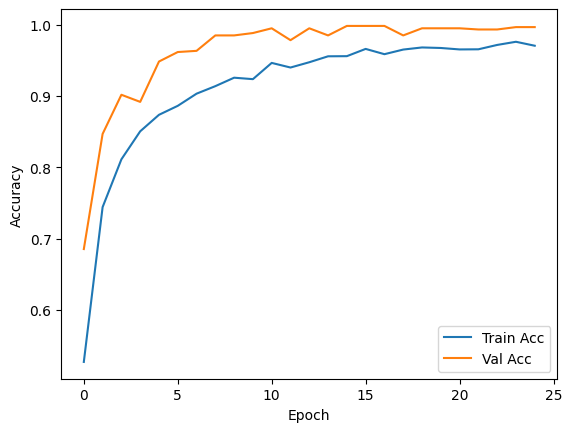

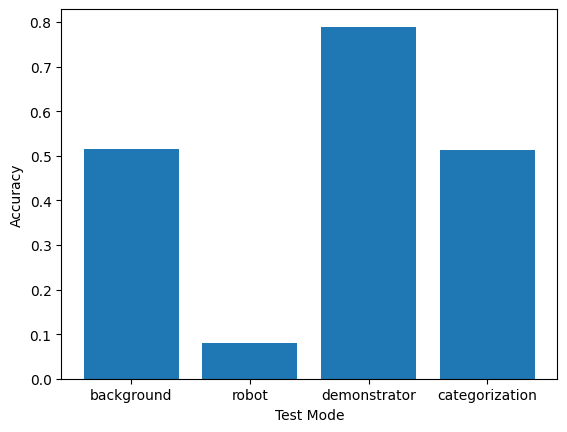

{'background': np.float64(0.515), 'robot': np.float64(0.0798004987531172), 'demonstrator': np.float64(0.7896051974012993), 'categorization': np.float64(0.5137431284357821)}


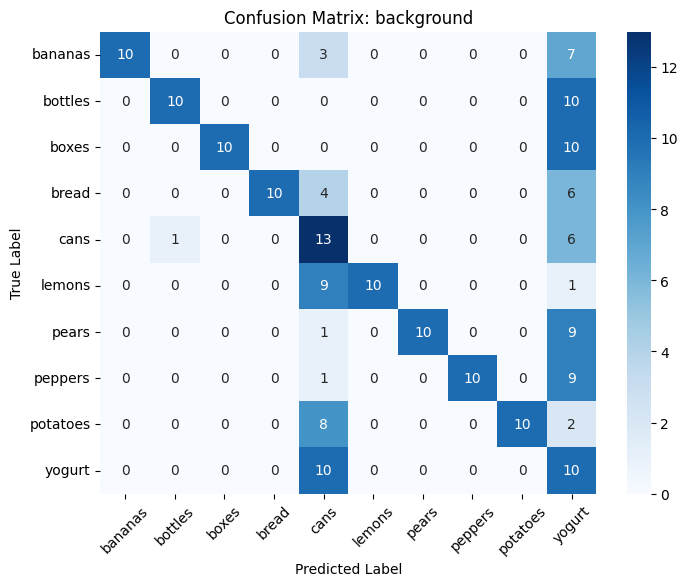

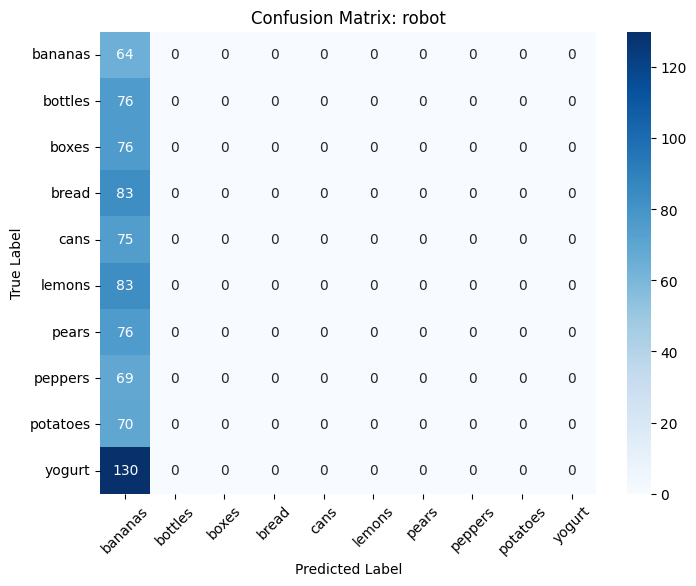

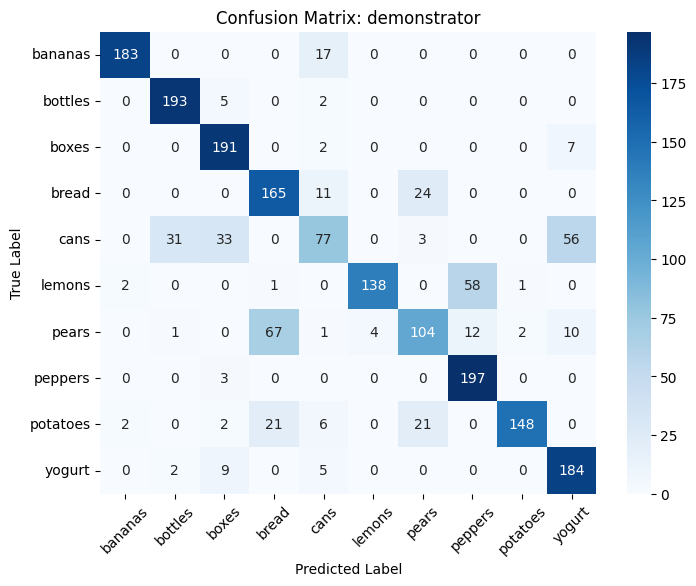

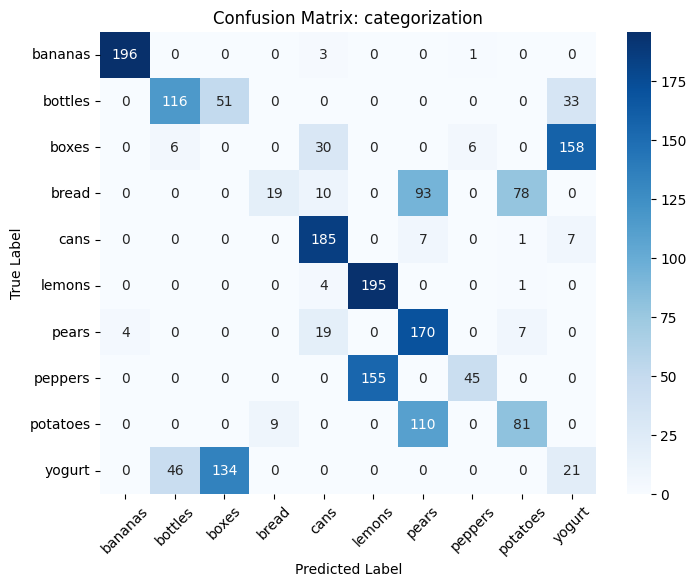

In [12]:
from sklearn.metrics import classification_report
import seaborn as sns
# 训练/验证曲线
plt.figure()
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'],   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

# 测试模式柱状图
plt.figure()
plt.bar(results_test.keys(), results_test.values())
plt.xlabel('Test Mode'); plt.ylabel('Accuracy'); plt.show()
print(results_test)

# 混淆矩阵可视化
for mode, cm in conf_mats.items():
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=base_ds.classes, yticklabels=base_ds.classes)
    plt.title(f'Confusion Matrix: {mode}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()